<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/Copie_de_Cnn_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
import tensorflow as tf
import copy as cp

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random as rd

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('/content/df_cov_continu_1_8.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df.iloc[:,3]))
df_train=df.iloc[0:round(N*0.8),:]
df_test=df.iloc[round(N*0.8):N,:]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [ ]:
RSG_train = df_train[mesure[10]].values
RSG_test=df_test[mesure[10]].values
window_len=2500
long=len(RSG_train)
long_test=len(RSG_test)
Q=long-window_len
Q_test=long_test-window_len
Spectro=np.zeros((1000,11,Q-1))
Spectro_test=np.zeros((1000,11,Q_test-1))
Y=[]
Y_test=[]

In [ ]:

Q=long-window_len
scalers=[]
for j in range(Q-1):
  f, t, Sxx = signal.spectrogram(RSG_train[0+j:window_len+j], fs=1/120,nfft=2**13)
  inter=20*np.log10(cp.deepcopy(Sxx[0:1000,:]))
  Spectro[:,:,j]=inter
  Y.append(RSG_train[window_len+j])
  #plt.pcolormesh(t, f[0:1000], Spectro[:,:,j],cmap='jet')
  #plt.ylabel('Frequency [Hz]')
  #plt.xlabel('Time [sec]')
  #plt.show()
for j in range(Q_test-1):
  f, t, Sxx = signal.spectrogram(RSG_test[0+j:window_len+j], fs=1/120,nfft=2**13)
  inter=20*np.log10(cp.deepcopy(Sxx[0:1000,:]))
  Spectro_test[:,:,j]=inter
  Y_test.append(RSG_test[window_len+j])
min=np.min(Spectro)
max=np.max(Spectro)
Spec_scaled=(-1/(min-max))*(Spectro-max)+1
min1=np.min(Spectro_test)
max1=np.max(Spectro_test)
Spec_test_scaled=(-1/(min1-max1))*(Spectro_test-max1)+1
Y = np.array(Y)
Y_test=np.array(Y_test)
scaler=MinMaxScaler()
scaler.fit(Y.reshape(-1,1))  
Y_scaled=scaler.transform(Y.reshape(-1,1))
Y_test_scaled=scaler.transform(Y_test.reshape(-1,1))
  
  

In [ ]:
def autocorr_matrix(x,order):
    R = np.zeros((order, order))
    for i in range(0,order):
        for j in range(0,order):
            R[i,j] = autocorrelate(x, abs(i-j))
    return R
def autocorrelate(x,lag):
    return np.correlate(x[0:len(x)-lag],x[lag:len(x)])

In [ ]:
taille=30
longueur=len(RSG_train)
longueur_test=len(RSG_test)

In [ ]:
autocor=np.zeros((taille,taille,longueur-taille))
autocor_test=np.zeros((taille,taille,longueur_test-taille))

In [ ]:
y_auto=[]
y_auto_test=[]
for j in range(longueur-taille):
  sig=RSG_train[j:j+taille]
  Auto_inter=autocorr_matrix(sig,taille)
  autocor[:,:,j]=Auto_inter
  y_auto.append(RSG_train[(j+taille)])
for j in range(longueur_test-taille):
  sig=RSG_test[j:j+taille]
  Auto_inter=autocorr_matrix(sig,taille)
  autocor_test[:,:,j]=Auto_inter
  y_auto_test.append(RSG_train[(j+taille)])
y_auto=np.array(y_auto)
y_auto_test=np.array(y_auto_test)
scaler2=MinMaxScaler()
scaler2_test=MinMaxScaler()
scaler2.fit(y_auto.reshape(-1,1))
scaler2_test.fit(y_auto_test.reshape(-1,1))
y_auto_scaled=scaler2.transform(y_auto.reshape(-1,1))
y_auto_test_scaled=scaler2_test.transform(y_auto_test.reshape(-1,1))
min_a=np.amin(autocor)
max_a=np.amax(autocor)
autocor_scaled=(-1/(min_a-max_a))*(autocor-max_a)+1
min_a_test=np.amin(autocor_test)
max_a_test=np.amax(autocor_test)
autocor_test_scaled=(-1/(min_a_test-max_a_test))*(autocor_test-max_a_test)+1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
Spec_scaled = np.array(Spec_scaled).reshape(Q-1,1000,11,1)
Spec_test_scaled=np.array(Spec_test_scaled).reshape(Q_test-1,1000,11,1)
print(Spec_scaled.shape)

(9387, 1000, 11, 1)


In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(taille,taille, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [ ]:
N=100
#plt.figure(figsize=(7,5))
#plt.pcolormesh(Spectro[0,:,:],cmap='jet')
#plt.colorbar

In [ ]:
autocor_scaled=autocor_scaled.reshape(11858,30,30)
autocor_test_scaled=autocor_test_scaled.reshape(2942,30,30)
cnn.compile(optimizer='adam',
              loss='mse')
cnn.fit(autocor_scaled,y_auto_scaled,epochs=20, verbose=1,batch_size=100,validation_data=(autocor_test_scaled,y_auto_test_scaled))

Epoch 1/20
119/119 [==============================] - 8s 61ms/step - loss: 0.0558 - val_loss: 0.0410
Epoch 2/20
119/119 [==============================] - 6s 48ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 3/20
119/119 [==============================] - 6s 48ms/step - loss: 0.0378 - val_loss: 0.0398
Epoch 4/20
119/119 [==============================] - 6s 48ms/step - loss: 0.0376 - val_loss: 0.0358
Epoch 5/20
119/119 [==============================] - 6s 48ms/step - loss: 0.0377 - val_loss: 0.0377
Epoch 6/20
119/119 [==============================] - 6s 47ms/step - loss: 0.0370 - val_loss: 0.0367
Epoch 7/20
119/119 [==============================] - 6s 47ms/step - loss: 0.0372 - val_loss: 0.0356
Epoch 8/20
119/119 [==============================] - 6s 47ms/step - loss: 0.0369 - val_loss: 0.0350
Epoch 9/20
119/119 [==============================] - 7s 57ms/step - loss: 0.0368 - val_loss: 0.0362
Epoch 10/20
119/119 [==============================] - 6s 48ms/step - loss: 0.0369 - val_lo

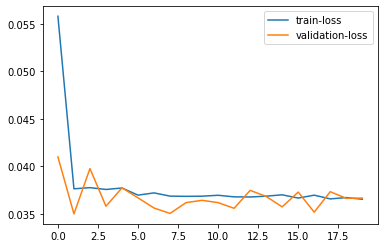

In [ ]:
loss_per_epoch = cnn.history.history['loss']
loss_vall=cnn.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.legend()

In [ ]:
trainPredict = cnn.predict(autocor_scaled)
Y_true=scaler2.inverse_transform(trainPredict)
RSG_train=RSG_train.tolist()
Y_true=Y_true.tolist()

In [ ]:
Q=0
N=9000

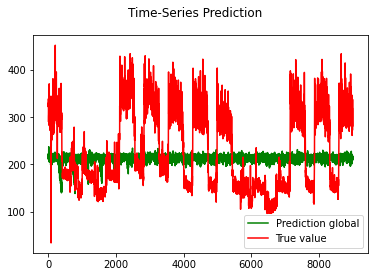

In [ ]:
plt.suptitle('Time-Series Prediction')
plt.plot(range(len(Y_true[Q:Q+N])),Y_true[Q:Q+N],label='Prediction global',c="green")
plt.plot(range(len(Y_true[Q:Q+N])),RSG_train[Q:Q+N],label='True value',c="red")
plt.legend()
plt.show()